In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
# select/limit gpu availability to a single device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import sys, os, warnings, time, logging
from functools import partial
import copy
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.core.decorators import auto_move_data
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from einops import rearrange, repeat

import numpy as np
import matplotlib.pyplot as plt
import torchvision
from tqdm.autonotebook import tqdm

from lightning_addons.lightprogressbar import LightProgressBar
from lightning_addons.progressplotter import ProgressPlotter
from lightning_addons.progressprinter import ProgressPrinter

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
# this makes lightning reports not look like errors
pl._logger.handlers = [logging.StreamHandler(sys.stdout)]

print("python", sys.version, sys.executable)
print("pytorch", torch.__version__)
print("torchvision", torchvision.__version__)
print("pytorch-lightning", pl.__version__)

python 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0] /home/mtadmin/miniconda3/envs/dev_pytorch18/bin/python
pytorch 1.8.1
torchvision 0.9.1
pytorch-lightning 1.2.10


In [4]:
def to_3channel(image):
    return image.repeat((3, 1, 1))

## mnist

In [5]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, n_workers, train_fraction=0.7, extra_transforms=None, data_dir="data/mnist"):
        super().__init__()
        self.batch_size = batch_size
        self.n_workers = n_workers
        self.train_fraction = train_fraction
        self.data_dir = data_dir
        transforms = [torchvision.transforms.ToTensor(),]
        if extra_transforms is not None:
            transforms += extra_transforms
        self.transform = torchvision.transforms.Compose(transforms)
        
    def prepare_data(self):
        # this is intended to just run the download
        torchvision.datasets.MNIST(self.data_dir, download=True, train=True)
        torchvision.datasets.MNIST(self.data_dir, download=True, train=False)
        
    def setup(self, stage=None):
        # this can potentially be run on different machines and GPUs hence the actual preperation should be done here
        if stage == "fit" or stage is None:
            trainval_data = torchvision.datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            n_trainval = len(trainval_data)
            n_train = int(self.train_fraction * n_trainval)
            self.train_data = torch.utils.data.Subset(trainval_data, range(0, n_train))
            self.val_data = torch.utils.data.Subset(trainval_data, range(n_train, n_trainval))
            # if we set this here we get the actual transformed size, which is nice at it does not require prior knowledge as in __init__()
            self.dims = tuple(self.train_data[0][0].shape)
        if stage == "test" or stage is None:
            self.test_data = torchvision.datasets.MNIST(self.data_dir, train=False, transform=self.transform)
            self.dims = tuple(self.test_data[0][0].shape)
        
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.n_workers, shuffle=True)
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.n_workers)
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.n_workers)

output_size = 28

# data standard normalization parameters:
# to compute mean and std
# norm_mean = 0.
# norm_std = 1.
# default
# norm_mean = 0.5
# norm_std = 0.5
# imagenet
# norm_mean = [0.485, 0.456, 0.406]
# norm_std = [0.229, 0.224, 0.225]
# mnist 
norm_mean = [0.1311, 0.1311, 0.1311]
norm_std = [0.3087, 0.3087, 0.3087]

# TODO: we can do better by actually computing these values from mnist
extra_transforms = [
    torchvision.transforms.Resize(output_size),
    to_3channel,  # we use 3 channels to directly use (pretrained) ResNets
    torchvision.transforms.Normalize(norm_mean, norm_std),
]
mnist_data = MnistDataModule(32, 8, extra_transforms=extra_transforms)
mnist_data.prepare_data()
mnist_data.setup()
mnist_data.size(), len(mnist_data.train_dataloader().dataset), len(mnist_data.val_dataloader().dataset), len(mnist_data.test_dataloader().dataset)

((3, 28, 28), 42000, 18000, 10000)

## select dataset

In [6]:
data = mnist_data

## compute normalization stats

In [7]:
# # compute mean and std etc
# input_key = 0
# def collect_stats(sample):
#     image = sample[input_key]
#     return image.sum((1, 2)), (image ** 2).sum((1, 2))#, image.mean((1, 2)), image.min((1, 2)), image.max((1, 2))

# all_stats = [collect_stats(sample) for sample in tqdm(data.train_dataloader().dataset)]
# sums, squared_sums= [torch.stack(stats, 0) for stats in (zip(*all_stats))]
# # # , means, mins, maxs 
# input_shape = data.train_dataloader().dataset[0][input_key].shape
# input_area = input_shape[1] * input_shape[2]

# ds_mean = sums.mean(0) / input_area
# ds_std = (squared_sums.mean(0) / input_area - ds_mean ** 2).sqrt()
# ds_mean, ds_std

## check samples

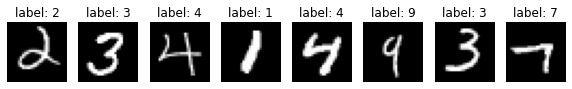

In [8]:
dataloader = data.train_dataloader()
batch = next(iter(dataloader))
# 0: input, 1: target
n_samples = 8
f, axs = plt.subplots(1, n_samples, figsize=(10, 5))
for i, ax in enumerate(axs):
    sample_image = batch[0][i]
    sample_target = batch[1][i]
    ax.imshow(sample_image.permute(1, 2, 0).mul(torch.as_tensor(norm_std)).add(torch.as_tensor(norm_mean)).clamp(0.0, 1.0))
    ax.set_title(f"label: {sample_target.numpy()}");
    ax.axis(False);

## resnet model

In [9]:
class ResNetModel(pl.LightningModule):
    def __init__(self, data_shape, num_classes, 
                 learning_rate, momentum=0.9, weight_decay=5e-4,
                 pretrained=False, activation="softmax", sigmoid_soft_factor=1.0, scheduler="one_cycle"):
        super().__init__()
        self.save_hyperparameters()

        # torchvision's resnet18 does not allow pretraining for num_classes != 1000
        assert pretrained == False
        self.resnet = torchvision.models.resnet18(num_classes=num_classes)
    
#         # to use pretraining simply replace last linear layer with one mathcing num_classes
#         self.resnet = torchvision.models.resnet18(pretrained=pretrained)
#         self.resnet.fc = torch.nn.Linear(512, 10)
        
        # this allows the trainer to show input and output sizes in the report (1 is just a sample batch size)
        self.example_input_array = torch.zeros(1, *data_shape)
        
        self.train_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.val_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_confmatrix = pl.metrics.ConfusionMatrix(num_classes, compute_on_step=False)
        
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=self.hparams.momentum, weight_decay=self.hparams.weight_decay)
        schedulers = []
        if self.hparams.scheduler == "one_cycle":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.learning_rate,
                epochs=max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy="cos", # can be "linear" or "cos"(default)
                three_phase=False,
            )
            # "interval: step" is required to let the scheduler update per step rather than epoch
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif self.hparams.scheduler == "cosine_annealing":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            max_steps = max_epochs * steps_per_epoch
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=max_steps,
            )
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif isinstance(self.hparams.scheduler, type) or isinstance(self.hparams.scheduler, partial):
            schedulers = [self.hparams.scheduler(optimizer)]
        return [optimizer], schedulers
    
    def class_activation(self, x):
        if self.hparams.activation == "softmax":
            return x.softmax(1)
        elif self.hparams.activation == "sigmoid":
            return x.sigmoid()
        
    def class_loss(self, y_hat, y):
        # y_hat: prediction, y: target
        if self.hparams.activation == "softmax":
            return torch.nn.functional.cross_entropy(y_hat, y)
        elif self.hparams.activation == "sigmoid":
            y = y.float()
            y = y * self.hparams.sigmoid_soft_factor
            y[y == 0] = (1.0 - self.hparams.sigmoid_soft_factor) / (self.hparams.num_classes - 1)
            return torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)
    
    def _forward(self, x):
        return self.resnet(x)
    
    def training_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("loss", loss)
        self.train_acc.update(self.class_activation(preds), targets)
        # the accuracies are updated here, but only computed and reported at the epoch, see "compute_on_step=False", "on_step=False", "on_epoch=True"
        self.log('train_acc', self.train_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("val_loss", loss)
        self.val_acc.update(self.class_activation(preds), targets)
        self.log('val_acc', self.val_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        preds = self._forward(images)
        loss = self.class_loss(preds, targets)
        self.log("test_loss", loss)
        self.test_acc.update(self.class_activation(preds), targets)
        self.log('test_acc', self.test_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.test_confmatrix.update(self.class_activation(preds), targets)
        return loss
    
    # this moves data to gpu when forward is called
    @auto_move_data
    def forward(self, x):
        # in pl forward() is intended for inference, hence the activation is done here
        logits = self._forward(x)
        return self.class_activation(logits)

num_classes = 10
learning_rate = 1e-1
# momentum = 0
# weight_decay = 0
momentum = 0.9
weight_decay = 5e-4
pretrained = False
activation = "softmax"
# activation = "sigmoid"
sigmoid_soft_factor = 0.9 # soft label: this is a multiplier to reduce the one hot 1s in case of sigmoid to a smaller value
# sigmoid_soft_factor = 1.0
scheduler = "one_cycle" # "cosine_annealing" or None
# one can also pass a partial scheduler class like the following to use other schedulers
# scheduler = partial(torch.optim.lr_scheduler.MultiStepLR, milestones=[3, 6], gamma=0.1)

rn_model = ResNetModel(
    data.size(), 
    num_classes, 
    learning_rate, 
    momentum=momentum, 
    weight_decay=weight_decay,
    pretrained=pretrained, 
    activation=activation,
    sigmoid_soft_factor=sigmoid_soft_factor,
    scheduler=scheduler,
)
rn_model.hparams

"activation":          softmax
"data_shape":          (3, 28, 28)
"learning_rate":       0.1
"momentum":            0.9
"num_classes":         10
"pretrained":          False
"scheduler":           one_cycle
"sigmoid_soft_factor": 0.9
"weight_decay":        0.0005

# vision transformer

In [10]:
from einops.layers.torch import Rearrange

class ViT(pl.LightningModule):
    def __init__(self, data_shape, patch_size, num_classes, dim, depth, heads, mlp_dim,
                 pool = 'cls', dim_head = 64, dropout = 0., emb_dropout = 0.,
                 lr=3e-5, momentum=0.9, weight_decay=5e-4,scheduler="one_cycle", activation="softmax"):
        super().__init__()
        self.save_hyperparameters()
        assert activation == "softmax"
        assert data_shape[1] % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (data_shape[1] // patch_size) ** 2
        patch_dim = data_shape[0] * patch_size ** 2
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )
        # TODO: play with this - use a conv instead of the self.to_patch_embedding above
#         self.patch_conv = nn.Conv2d(3, 1024, kernel_size=7, stride=7)
#         self.patch_conv = nn.Conv2d(3, 1024, kernel_size=25, stride=1)

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))

        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)
        
        encoder_layer = nn.TransformerEncoderLayer(dim, heads, activation="gelu")
        self.transformer = nn.TransformerEncoder(encoder_layer, depth)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )
        
        # this allows the trainer to show input and output sizes in the report (1 is just a sample batch size)
        self.example_input_array = torch.zeros(1, *data_shape)
        
        self.train_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.val_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_acc = pl.metrics.Accuracy(compute_on_step=False)
        self.test_confmatrix = pl.metrics.ConfusionMatrix(num_classes, compute_on_step=False)
        
    def class_activation(self, x):
        if self.hparams.activation == "softmax":
            return x.softmax(-1)
        elif self.hparams.activation == "sigmoid":
            return x.sigmoid()
        
    def class_loss(self, y_hat, y):
        # y_hat: prediction, y: target
        if self.hparams.activation == "softmax":
            return torch.nn.functional.cross_entropy(y_hat, y)
        elif self.hparams.activation == "sigmoid":
            y = y.float()
            y = y * self.hparams.sigmoid_soft_factor
            y[y == 0] = (1.0 - self.hparams.sigmoid_soft_factor) / (self.hparams.num_classes - 1)
            return torch.nn.functional.binary_cross_entropy_with_logits(y_hat, y)

    def _forward(self, img, mask=None):
        x = self.to_patch_embedding(img)
        # TODO: see comment above to play with this
#         x = self.patch_conv(img).flatten(2, 3).permute(0, 2, 1)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)
        # NOTE: be aware that pytorch's transformers expect batches like [SQLxBSZxFTS] instead of [BSZxSQLxFTS]
        x = x.permute(1, 0, 2)
        x = self.transformer(x, mask)
        x = x.permute(1, 0, 2)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)
    
    @auto_move_data
    def forward(self, img, mask=None):
        y_hat = self._forward(img, mask)
        y_hat = self.class_activation(y_hat)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        schedulers = []
        if self.hparams.scheduler == "one_cycle":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            scheduler = torch.optim.lr_scheduler.OneCycleLR(
                optimizer,
                max_lr=self.hparams.lr,
                epochs=max_epochs,
                steps_per_epoch=steps_per_epoch,
                anneal_strategy="cos", # can be "linear" or "cos"(default)
                three_phase=False,
            )
            # "interval: step" is required to let the scheduler update per step rather than epoch
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif self.hparams.scheduler == "cosine_annealing":
            steps_per_epoch = int(self.trainer.limit_train_batches * len(self.train_dataloader())) # same as batches per epoch
            max_epochs = self.trainer.max_epochs
            max_steps = max_epochs * steps_per_epoch
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                optimizer,
                T_max=max_steps,
            )
            schedulers = [{"scheduler": scheduler, "interval": "step", "frequency": 1}]
        elif isinstance(self.hparams.scheduler, type) or isinstance(self.hparams.scheduler, partial):
            schedulers = [self.hparams.scheduler(optimizer)]
        return [optimizer], schedulers
    
    def training_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("loss", loss)
        self.train_acc.update(self.class_activation(logits), targets)
        # the accuracies are updated here, but only computed and reported at the epoch, see "compute_on_step=False", "on_step=False", "on_epoch=True"
        self.log('train_acc', self.train_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("val_loss", loss)
        self.val_acc.update(self.class_activation(logits), targets)
        self.log('val_acc', self.val_acc, prog_bar=False, on_step=False, on_epoch=True)
        return loss
    
    def test_step(self, batch, batch_nb):
        images, targets = batch
        if self.hparams.activation == "sigmoid":
            targets = torch.nn.functional.one_hot(targets, num_classes=self.hparams.num_classes)
        
        logits = self._forward(images)
        loss = self.class_loss(logits, targets)
        self.log("test_loss", loss)
        self.test_acc.update(self.class_activation(logits), targets)
        self.log('test_acc', self.test_acc, prog_bar=False, on_step=False, on_epoch=True)
        self.test_confmatrix.update(self.class_activation(logits), targets)
        return loss
    
patch_size = 7
num_classes = 10
lr = 1e-4
scheduler = "one_cycle"
# TODO: play with the hyperparameters like detph, heads, etc
# compared to the notebook with the lucidrains implementation, the depth and heads are reduced here
# original values are behind the #
vit_model = ViT(
    data.size(),
    patch_size=patch_size,
    num_classes=num_classes,
    dim=2048, # 1024
    depth=2, # 6
    heads=16, # 16
    mlp_dim=2048, # 2048
    dropout=0.1,
    emb_dropout=0.1,
    lr=lr,
    scheduler=scheduler,
    pool="cls", #"cls"
)

img = torch.randn(1, 3, 28, 28)
mask = torch.ones(1, 8, 8).bool() # optional mask, designating which patch to attend to

preds = vit_model(img)#, mask = mask) # (1, 1000)
preds.shape

torch.Size([1, 10])

## train model

In [11]:
# run this to show very detailed model information and if model has example_input_array also detailed feature sizes
# pl.core.memory.ModelSummary(model, mode="full")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type               | Params | In sizes             | Out sizes    
-------------------------------------------------------------------------------------------------
0 | to_patch_embedding | Sequential         | 303 K  | [1, 3, 28, 28]       | [1, 16, 2048]
1 | dropout            | Dropout            | 0      | [1, 17, 2048]        | [1, 17, 2048]
2 | transformer        | TransformerEncoder | 50.4 M | [[17, 1, 2048], '?'] | [17, 1, 2048]
3 | to_latent          | Identity           | 0      | [1, 2048]            | [1, 2048]    
4 | mlp_head           | Sequential         | 24.6 K | [1, 2048]            | [1, 10]      
5 | train_acc          | Accuracy           | 0      | ?                    | ?            
6 | val_acc            | Accuracy           | 0      | ?                    | ?            
7 | test_acc        

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

epoch,loss,val_loss,val_acc,train_acc,time
0,0.241000,0.240217,0.928444,0.840571,0:00:35
1,0.248000,0.212477,0.935556,0.928690,0:00:35
2,0.204000,0.174586,0.946556,0.931690,0:00:35
3,0.174000,0.139458,0.957222,0.947309,0:00:35
4,0.104000,0.112376,0.967056,0.956452,0:00:34
5,0.079000,0.086945,0.973444,0.966190,0:00:35
6,0.086200,0.072661,0.977944,0.975714,0:00:35
7,0.025900,0.060080,0.981722,0.984071,0:00:34
8,0.040000,0.053359,0.984611,0.991595,0:00:35
9,0.022400,0.053028,0.985000,0.995286,0:00:34


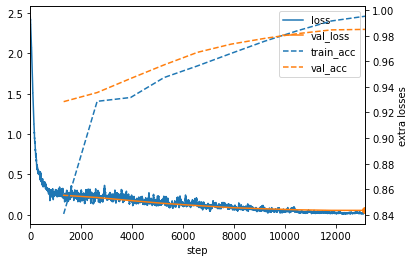

runtime: 371 s


In [12]:
tb_logger = pl.loggers.TensorBoardLogger("/home/mtadmin/projects/tensorboard_logs")

plotter = ProgressPlotter()
callbacks = [
    LightProgressBar(),
    ProgressPrinter(),
    plotter,
    LearningRateMonitor(log_momentum=True),
]

# early_stop_callback = EarlyStopping(
#     monitor="val_loss",
#     mode="min",
#     patience=5,
#     verbose=True,
# )
# callbacks = [early_stop_callback] + callbacks


# model_checker = ModelCheckpoint(
#     monitor="val_loss",
#     mode="min",
#     save_last=True, 
#     save_top_k=1, 
#     filename="best_{epoch}",
# )
# callbacks += [model_checker]

# model = rn_model # baseline model
model = vit_model

max_epochs = 10
limit_train_batches = 1.0
# limit_train_batches = 0.1 # 1.0 by default/full set, use this to check training on a smaller train set, also exists for val and test set
trainer = pl.Trainer(
    max_epochs=max_epochs, 
    gpus=1,
    callbacks=callbacks,
    logger=[tb_logger],
    precision=16,
#     fast_dev_run=True, 
    limit_train_batches=limit_train_batches,
)

start_time = time.time()
trainer.fit(model, data)
print(f"runtime: {time.time() - start_time:.0f} s")

# we aim for ~99 %

In [13]:
# trainer.logger.log_dir
# trainer.checkpoint_callback.best_model_path

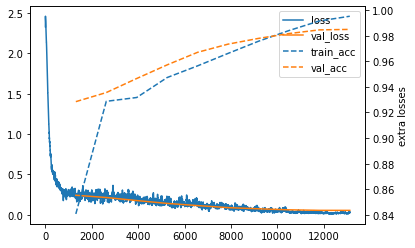

In [14]:
# static plot after training, useful when coming back after training finished
plotter.static_plot()

In [15]:
trainer.test(verbose=False)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[{'test_loss': 0.045703209936618805, 'test_acc': 0.9855999946594238}]

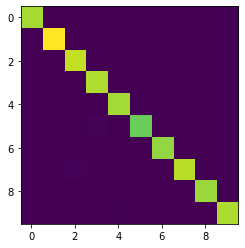

In [16]:
plt.imshow(model.test_confmatrix.compute().cpu())

## compute accuracy the hard way

In [17]:
model.eval()
all_targets = []
all_scores = []
for images, targets in tqdm(data.test_dataloader()):
    with torch.no_grad():
        scores = model(images).cpu().float()
        all_scores.append(scores)
        all_targets.append(targets)
        
scores = torch.cat(all_scores)
targets = torch.cat(all_targets)

  0%|          | 0/313 [00:00<?, ?it/s]

In [18]:
accuracy = (scores.max(1)[1] == targets).sum() / float(len(targets))
accuracy

tensor(0.9856)